In [1]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import datetime
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

### Визуализация

In [2]:
df = pd.read_csv("dataset.csv", on_bad_lines='skip').dropna()

In [3]:
df

,rssi,distanceFromRssi,receiver_lat,receiver_lon,transmitter_lat,transmitter_lon,target_lon,target_lat
0,-77.748789,10.465356,60.009758,30.377302,60.009711,30.377310,30.377307,60.009672
1,-78.188214,10.893238,60.009758,30.377302,60.009709,30.377311,30.377307,60.009672
2,-78.614212,11.324739,60.009758,30.377302,60.009708,30.377315,30.377307,60.009672
3,-79.027257,11.759434,60.009758,30.377302,60.009705,30.377311,30.377307,60.009672
4,-79.427800,12.196901,60.009758,30.377302,60.009703,30.377312,30.377307,60.009672
...,...,...,...,...,...,...,...,...
450,-81.109082,14.217883,60.009758,30.377302,60.009716,30.377206,30.377307,60.009672
451,-81.022379,14.105911,60.009758,30.377302,60.009716,30.377207,30.377307,60.009672
452,-80.742884,13.750929,60.009758,30.377302,60.009717,30.377209,30.377307,60.009672
453,-80.666393,13.655345,60.009758,30.377302,60.009718,30.377210,30.377307,60.009672


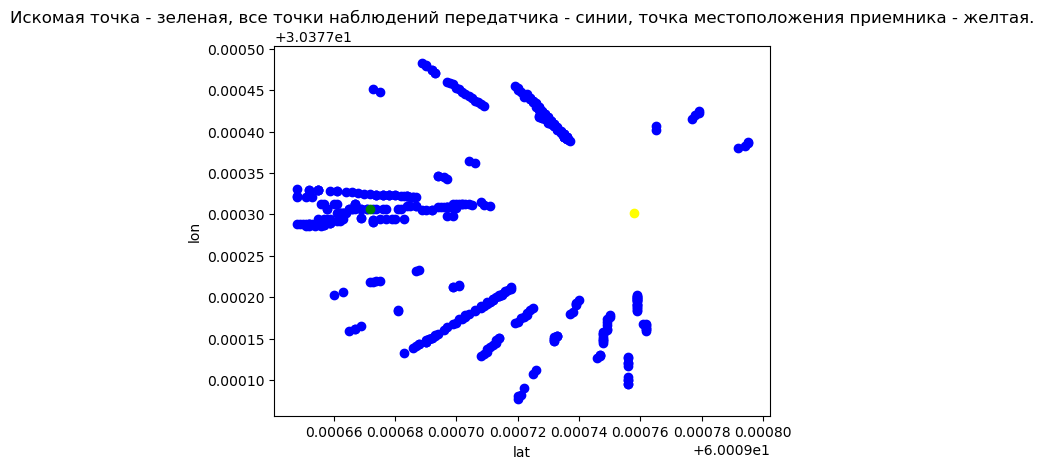

In [4]:
plt.scatter(df["transmitter_lat"], df["transmitter_lon"], c = 'b');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'green');
plt.scatter(df["receiver_lat"][0], df["receiver_lon"][0], c = 'yellow');
plt.title("Искомая точка - зеленая, все точки наблюдений передатчика - синии, точка местоположения приемника - желтая.");
plt.xlabel("lat")
plt.ylabel("lon");

Точки в основном расположены в некоторых участках с высокой плотностью, отклонение наблюдений от искомой точки относительно приемника может быть очень сильным.

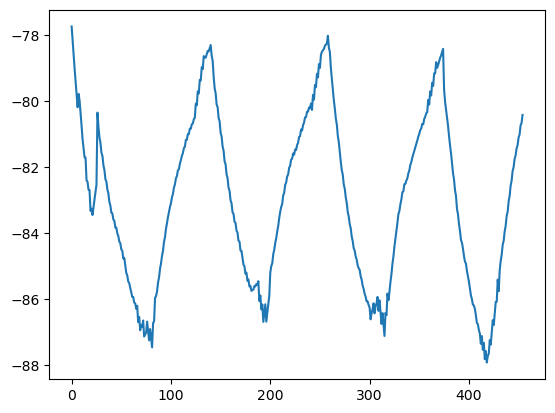

In [5]:
df['rssi'].plot();

Рассмотрим некоторые подходы к решению задачи

# Кластеризация 

Данные довольно сильно зашумлены, искомая точка находится в наиболее крупном кластере с высокой плотностью. 
Алгоритм кластеризации DBSCAN справляется с обеими задачами - очисткой от выбросов и разбиению на произвольное количество 
кластеров. Критерий разбиения и поиска выбросов - плотность, что согласуется с особенностями данных.
В алгоритме под плотностью в точке понимается количество точек, находящихся на расстоянии ближе фиксированного при инициализации радиуса.

Найдем среднее Евклидово расстояние dist между всеми точками.
Оно понадобится в качестве параметра инициализации DBSCAN.

In [6]:
k = 0
dist = 0
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        dist += ((df["transmitter_lat"][i] - df["transmitter_lat"][j]) ** 2 
                 + (df["transmitter_lon"][i] - df["transmitter_lon"][j]) ** 2)**(1/2)
        k += 1
dist /= k
dist

0.00013299208939939537

Зафиксриуем в качестве параметра плотности расстояние eps = dist / 10, (алгоритм работает с заранее заданным eps - разумно его взять средним расстоянием с некоторым коэффициентом). Алгоритм считает плотной ту точку, в гиперсфере радиуса eps которой находится min_samples точек. Изначально установим min_samples равным кол-ву точек в датасете (таким образом все точки изначально будут считаться выбросами) и будем уменьшать это значение пока после очередной итерации DBSCAN самым крупным кластером не станет кластер состоящий не из выбросов. Как только только такой кластер найдется мы его пометим как основной. Такой подход позволяет найти наиболее крупный и плотный кластер.

In [7]:
p = df.shape[0]
X = df[['transmitter_lat', 'transmitter_lon']]
cl = DBSCAN(eps = dist / 10, min_samples=p).fit(X)
mx_lbl = -1
while (mx_lbl == -1):
    p = int(p / 1.2)
    X = df[['transmitter_lat', 'transmitter_lon']]
    cl = DBSCAN(eps=dist / 10, min_samples=p).fit(X)
    values, counts = np.unique(cl.labels_, return_counts=True)
    ind = np.argmax(counts)
    mx_lbl = values[ind]

DBSCAN самостоятельно не может определить центр кластера, поэтому определим его средним значением широты и долготы по кластеру, в качестве радиуса выберем расстояние от центра до самой удаленной точки кластера

In [8]:
x = df["transmitter_lat"][cl.labels_ == mx_lbl].mean()
y = df["transmitter_lon"][cl.labels_ == mx_lbl].mean()
r = 0
for i in range(len(cl.labels_)):
    if cl.labels_[i] == mx_lbl and ((x - df["transmitter_lat"][i]) ** 2 + (y - df["transmitter_lon"][i]) ** 2)**(1/2) > r:
        r = ((x - df["transmitter_lat"][i]) ** 2 + (y - df["transmitter_lon"][i]) ** 2)**(1/2)
print(x, y, r) # радиус r используется для картинки

60.009671762237765 30.37730727972028 3.933194512315426e-05


In [9]:
rad = 0
for i in range(len(cl.labels_)):
    if cl.labels_[i] == mx_lbl and geodesic((x, y), (df["transmitter_lat"][i], df["transmitter_lon"][i])).meters > rad:
        rad = geodesic((x, y), (df["transmitter_lat"][i], df["transmitter_lon"][i])).meters
rad # радиус в метрах

4.374208258851744

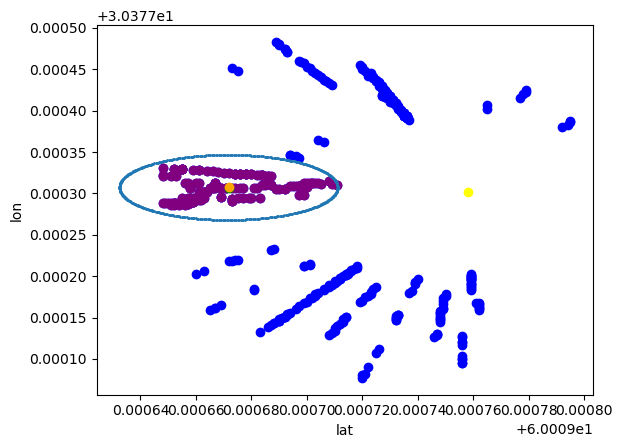

In [10]:
plt.scatter(df["transmitter_lat"], df["transmitter_lon"], c = 'b');
plt.scatter(df["transmitter_lat"][cl.labels_ == mx_lbl], df["transmitter_lon"][cl.labels_ == mx_lbl], c = 'purple');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'g')
plt.scatter(df["receiver_lat"].mean(), df["receiver_lon"].mean(), c = 'yellow')
plt.scatter(x, y, c = 'orange');

theta = np.linspace( 0 , 2 * np.pi , 500 )
radius = r
a = x + radius * np.cos( theta )
b = y + radius * np.sin( theta )
plt.scatter(a, b, s=1);
plt.xlabel("lat")
plt.ylabel("lon");

фиолетовые точки - самый крупный кластер, оранжевая точка - предсказанный центр (она почти полностью закрывает зеленую точку - истинный центр), голубым эллипсом (на самом деле это круг) помечен найденный радиус

Итого, предсказанные координаты и радиус:

In [11]:
x, y, rad

(60.009671762237765, 30.37730727972028, 4.374208258851744)

ошибка предсказания в метрах:

In [12]:
geodesic((x, y), (df["target_lat"][0], df["target_lon"][0])).meters

0.030743821428820085

Ошибка предсказания по евклидову расстоянию между координатами:

In [13]:
((x - df["target_lat"][0]) ** 2 + (y - df["target_lon"][0]) ** 2)**(1/2)

3.671162180757657e-07

DBSCAN показывает себя стабильно при сепмлировании исходного датасета, устойчив к сильным шумам в данных, самостоятельно определяет форму кластеров и их количество. Метод спуска позволяет за небольшое, порядка логарифма, количество запусков DBSCAN найти наиболее крупный плотный кластер. Выбросы и даже целые кластеры выбросов не будут влиять на предсказание. Потенциальный недостаток - время работы $O(n^2)$, при необходимости, можно попробовать уменьшить время работы семплированием датасета, несколько потеряв точность ответа.

Радиус взят с большим запасом, поскольку мы предполагаем, что точка лежит в кластере, вероятность что она находится на крае распределения очень мала (для этого нужно было бы, чтобы весь шум смещал показания только в одну сторону). Исходя из опыта использования можно будет скорректировать радиус - домножить на какой-то коэффициент. 

С задачей так же неплохо справляется родственный к DBSCAN алгоритм - HDBSCAN. Иные методы кластеризации (KMeans, SpectralClustering, Ward) показали себя в основном плохо, в кластеры выделялись очень разреженные области, что приводило к невозможности нахождения одновременно крупного и плотного кластера, который мы могли бы воспринимать как искомый. К тому же вероятна ситуация резделения искомого класса на несколько частей. Алгоритмы отличные от DBSCAN часто требуют заранее указывать количество кластеров, на практике трудно определить, сколько их должно быть, чтобы алгоритм сделал "правильное" разбиение.  

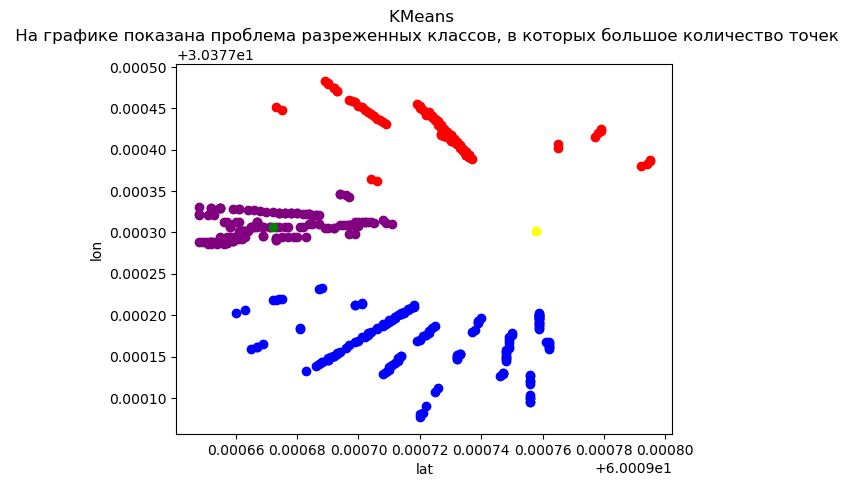

In [14]:
from sklearn.cluster import KMeans
cl = KMeans(n_clusters = 3).fit(X)
cl.labels_
plt.scatter(df["transmitter_lat"][cl.labels_ == 0], df["transmitter_lon"][cl.labels_ == 0], c = 'purple');
plt.scatter(df["transmitter_lat"][cl.labels_ == 1], df["transmitter_lon"][cl.labels_ == 1], c = 'b');
plt.scatter(df["transmitter_lat"][cl.labels_ == 2], df["transmitter_lon"][cl.labels_ == 2], c = 'r');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'g')
plt.scatter(df["receiver_lat"].mean(), df["receiver_lon"].mean(), c = 'yellow');
plt.title("KMeans \n На графике показана проблема разреженных классов, в которых большое количество точек");
plt.xlabel("lat")
plt.ylabel("lon");

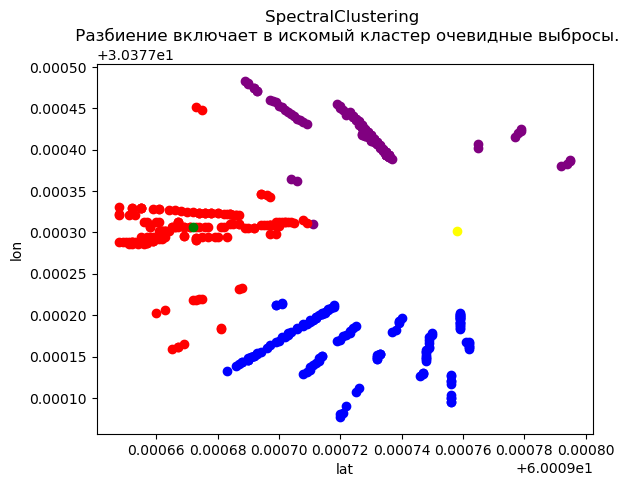

In [15]:
from sklearn.cluster import SpectralClustering
cl = SpectralClustering(n_clusters = 3).fit(X)
cl.labels_
plt.scatter(df["transmitter_lat"][cl.labels_ == 0], df["transmitter_lon"][cl.labels_ == 0], c = 'purple');
plt.scatter(df["transmitter_lat"][cl.labels_ == 1], df["transmitter_lon"][cl.labels_ == 1], c = 'b');
plt.scatter(df["transmitter_lat"][cl.labels_ == 2], df["transmitter_lon"][cl.labels_ == 2], c = 'r');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'g')
plt.scatter(df["receiver_lat"].mean(), df["receiver_lon"].mean(), c = 'yellow');
plt.title("SpectralClustering \n Разбиение включает в искомый кластер очевидные выбросы.");
plt.xlabel("lat")
plt.ylabel("lon");

# Борьба с выбросами

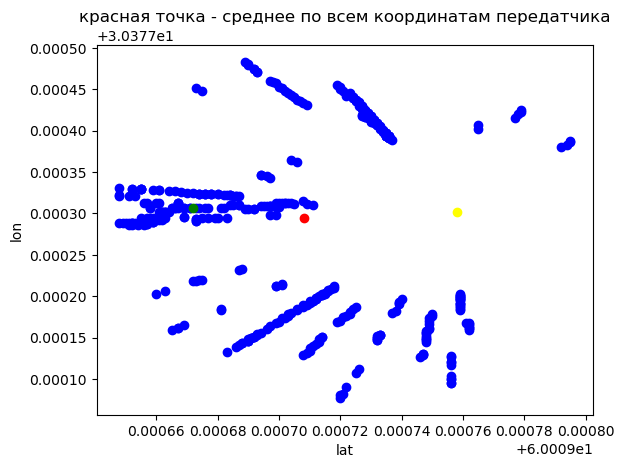

In [16]:
plt.scatter(df["transmitter_lat"], df["transmitter_lon"], c = 'b');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'green');
plt.scatter(df["receiver_lat"][0], df["receiver_lon"][0], c = 'yellow');
plt.scatter(df["transmitter_lat"].mean(), df["transmitter_lon"].mean(), c = 'red');
plt.title("красная точка - среднее по всем координатам передатчика");
plt.xlabel("lat")
plt.ylabel("lon");

Можно рассмотреть тривиальный подход и взять среднее по всем измерениям. Направление определено довольно точно, но из-за шума радиус сильно смещен.

Попробуем удалить выбросы с помощью различных алгоритмов, чтобы среднее сместилось в нужную сторону.

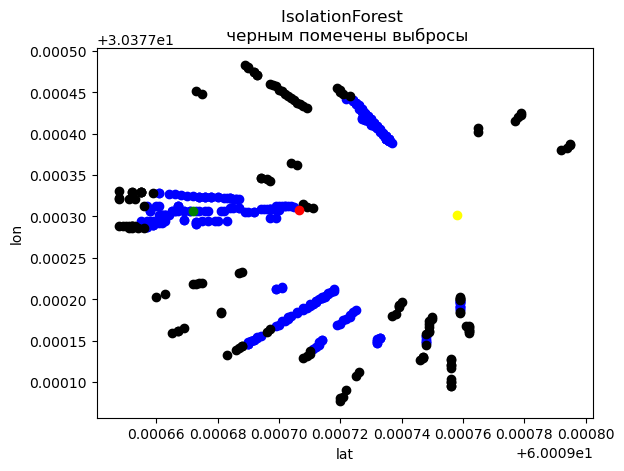

In [17]:
from sklearn.ensemble import IsolationForest
labels = IsolationForest(n_estimators = 100, random_state=0).fit_predict(X)
plt.scatter(df["transmitter_lat"][labels == 1], df["transmitter_lon"][labels == 1], c = 'blue');
plt.scatter(df["transmitter_lat"][labels == -1], df["transmitter_lon"][labels == -1], c = 'black');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'green');
plt.scatter(df["receiver_lat"][0], df["receiver_lon"][0], c = 'yellow');
plt.scatter(df["transmitter_lat"][labels == 1].mean(), df["transmitter_lon"][labels == 1].mean(), c = 'red');
plt.title("IsolationForest \n черным помечены выбросы");
plt.xlabel("lat")
plt.ylabel("lon");

IsolationForest на нашем примере провел странное разбиение на классы выбросов и обычных данных. Подбор гиперпараметров почти ничего не менят. Это связано с тем, что алгоритм использует предположение, что выбросы легче отделить несколькими прямыми, что приводит к тому, что выбросами оказываются края общего распределения.

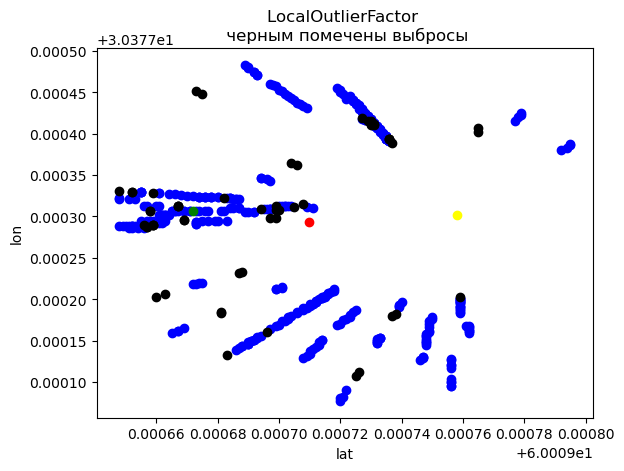

In [18]:
from sklearn.neighbors import LocalOutlierFactor
labels = LocalOutlierFactor(n_neighbors=3).fit_predict(X)
plt.scatter(df["transmitter_lat"][labels == 1], df["transmitter_lon"][labels == 1], c = 'blue');
plt.scatter(df["transmitter_lat"][labels == -1], df["transmitter_lon"][labels == -1], c = 'black');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'green');
plt.scatter(df["receiver_lat"][0], df["receiver_lon"][0], c = 'yellow');
plt.scatter(df["transmitter_lat"][labels == 1].mean(), df["transmitter_lon"][labels == 1].mean(), c = 'red');
plt.title("LocalOutlierFactor \n черным помечены выбросы");
plt.xlabel("lat")
plt.ylabel("lon");

LocalOutlierFactor плохо подходит под специфику задачи - выбросами он помечает точки, у которых плотность меньше чем у соседей. То есть в каждом отдельном скоплении точек он удаляет "края", вне зависимости от размера кластеров, что не подходит для нашей задачи.

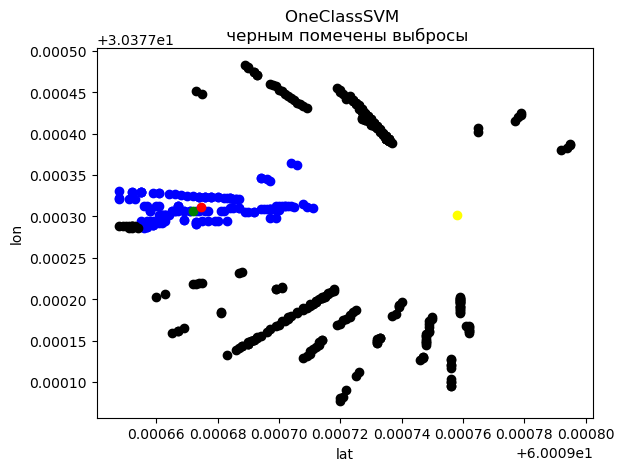

In [19]:
from sklearn.svm import OneClassSVM
labels = OneClassSVM(gamma='auto', nu=0.5).fit_predict(X)
plt.scatter(df["transmitter_lat"][labels == 1], df["transmitter_lon"][labels == 1], c = 'blue');
plt.scatter(df["transmitter_lat"][labels == -1], df["transmitter_lon"][labels == -1], c = 'black');
plt.scatter(df["target_lat"][0], df["target_lon"][0], c = 'green');
plt.scatter(df["receiver_lat"][0], df["receiver_lon"][0], c = 'yellow');
plt.scatter(df["transmitter_lat"][labels == 1].mean(), df["transmitter_lon"][labels == 1].mean(), c = 'red');
plt.title("OneClassSVM \n черным помечены выбросы");
plt.xlabel("lat")
plt.ylabel("lon");

OneClassSVM показал себя лучше, выбросами он пометил почти все точки, которые не входят в нужный нам кластер, погрешности незначительны. Это привело к тому, что мы довольно точно предсказали таргет средним значением, в отличии от предыдущих примеров. Однако алгоритм сильно зависит от параметра nu, отвечающего за процент выбросов. Таким образом алгоритм применим, только если мы знаем процент выбросов, иначе очень сильно падает точность предсказаний и стабильность (даже сдвиг на 0.05 может все испортить). Так что на практике алгоритм применим, если шум значительно слабее чем в нашем примере.

Итого, первые два примера удаления выбросов не подходят под задачу, у них неприменимый к нашей задаче критерий, по которому определяется, является ли точка выбросом. OneClassSVM можно пробовать использовать, но нужно быть уверенным в том, что данные не так сильно зашумлены. Но при таких подходах присутствует проблема определения радиуса области, в которой лежит передатчик, так как не исключена вероятность попадания в класс обычных данных далекой от истинного кластера точки.

# Приложение и его реализация

Для реализации поставленной задачи в приложении я выбрал DBSCAN с методом спуска по параметру min_samples. Он работает стабильнее, точнее и корректнее исходя из специфики задачи в сравнении с иными подходами, требует меньше предположений о данных, использует только фактор плотности.

pandas и numpy классические библиотеки для хранения датасета и работы с данными \
sklearn используется для применения алгоритма DBSCAN \
geodesic используется для нахождения расстояния между кооррдинатами по широте и долготе


Приложение на вход получает датасет аналогичный dataset.csv, но без полей target_lat, target_lon. Алгоритм DBSCAN запускается в цикле, уменьшая параметр min_samples в DESCENT_COEF раз с фиксированным eps, который равен среднему расстоянию по всем точкам домноженному на DIST_COEF. Как только DBSCAN находит крупный кластер состоящий не из выбрососв, по этому кластеру считаются средние широта и долгота - x и y. В качестве радиуса берется расстояние от точки (x, y) до самой удаленной точки кластера в метрах, которое считается через geopy.distance().

# Возможные методы решения более общей задачи 

В данной задаче передатчик статичен. Но можно рассматривать данные как временной ряд, где передатчик двигается со временем. В этом случае полезно использовать скользящее среднее. В таком подходе новые данные влияют сильнее на прогнозируемое местоположение, учитываются с большим весом, нежели чем старые. Но все равно остается значимой проблема выбросов. 

Чтобы решить проблему выбросов можно попробовать использовать алгоритм фильтра Калмана. Он предпологает, что мы знаем как должен двигаться передатчик, можем описать движение уравнением. Тогла фильтр Калмана сгладит выбросы.

По исходным данным так же можно посчитать некоторые физические параметры, которые потенциально могут понадобиться. \
Основная формула: 

# $$distance = 10^\frac{Measured Power - RSSI}{10n}$$

n - сопротивление среды \
MeasuredPower - сила RSSI, когда передатчик находится в 1 метре от приемника

Из уравнения следует \
$MeasuredPower - n * 10 * lg(distance) = RSSI$. \
Эта формула выполняется для каждой строчки датасета. \
В СЛУ уравений больше чем число неизвестных, поэтому найдем псведорешение т.е. найдем такие n и MeasuredPower, чтобы был наименьшим МНК \
$\sum_{i=1}^{len(df)}(RSSI - (MeasuredPower - n * 10 * lg(distance)))^2 \rightarrow min$ \
для этого воспользуемся LinearRegression из sklearn - она как раз и выполняет такую задачу аналитически

In [20]:
y = -df['rssi']
X = pd.DataFrame({"n": 10 * np.log10(df["distanceFromRssi"]), "MP": -np.ones(df.shape[0])})
lr = LinearRegression(fit_intercept = False).fit(X, y)
mp = lr.coef_[1]
n = lr.coef_[0]
mp, n

(-52.00000014151721, 2.5249999871630058)